In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd


In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Image not loaded. Check path or file format.")

    return image

In [ ]:
width = 5556
height = 4167
image_dim = (width, height)

In [ ]:
image_Aldha1a1_plus = load_image("Aldh1a1+.jpg")
image_Aldha1a1_plus = cv2.resize(image_Aldha1a1_plus, image_dim)

image_Aldha1a1_neg = load_image("Aldh1a1-.jpg")
image_Aldha1a1_neg = cv2.resize(image_Aldha1a1_neg, image_dim)

image_anxa_pos = load_image("anxa1+.jpg")
image_anxa_pos = cv2.resize(image_anxa_pos, image_dim)

image_anxa_neg = load_image("anxa1-.jpg")
image_anxa_neg = cv2.resize(image_anxa_neg, image_dim)

image_dorsal = load_image("dorsal.jpg")
image_dorsal = cv2.resize(image_dorsal, image_dim)

image_ventral = load_image("ventral.jpg")
image_ventral = cv2.resize(image_ventral, image_dim)

image_mask = load_image("mask.jpg")
image_mask = cv2.resize(image_mask, image_dim)

In [ ]:
image_micron = load_image("micron.jpg")
image_micron = cv2.resize(image_micron, image_dim)

In [ ]:
def plot(image_in):
  plt.imshow(image_in, cmap="gray")
  plt.axis("off")
  plt.show()

In [ ]:
images_in = [image_ventral, image_dorsal, image_mask, image_Aldha1a1_plus, image_Aldha1a1_neg, image_anxa_pos, image_anxa_neg, image_micron]
thresholds = [250] * len(images_in)

In [ ]:
def gaussian_blur(image_in):
  return cv2.GaussianBlur(image_in, (5, 5), 0)

Pre-Processing




*  Apply Gaussian Blur
*  Threshold each image and convert to a binary mask






In [ ]:
def preprocess(images_in, thresholds):
  images_out = []
  for i in range(len(images_in)):
    image_blur = images_in[i]
    _, mask = cv2.threshold(image_blur, thresholds[i], 255, cv2.THRESH_BINARY_INV)
    images_out.append(mask)
  return images_out

(4167, 5556)


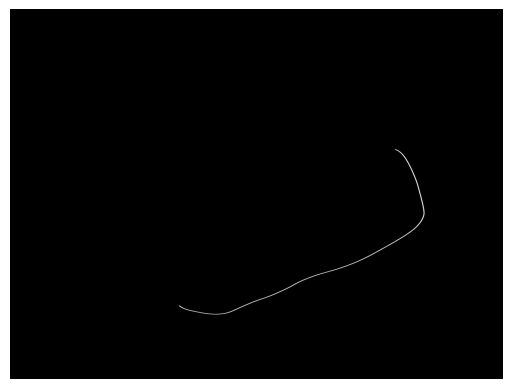

(4167, 5556)


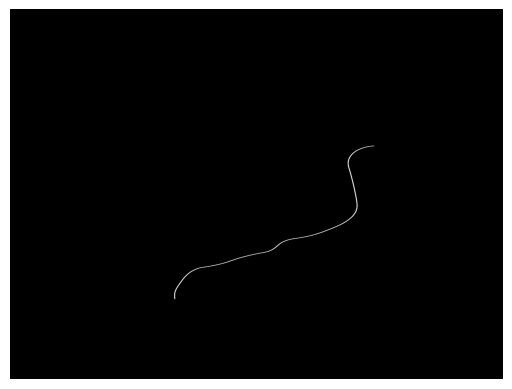

(4167, 5556)


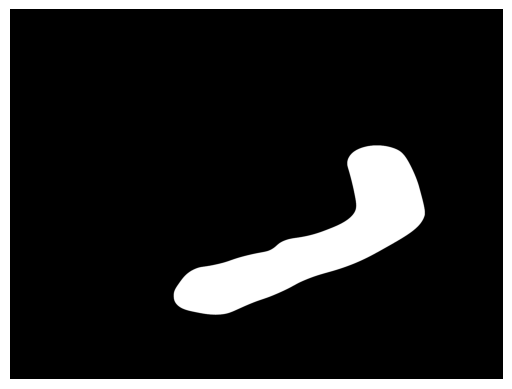

(4167, 5556)


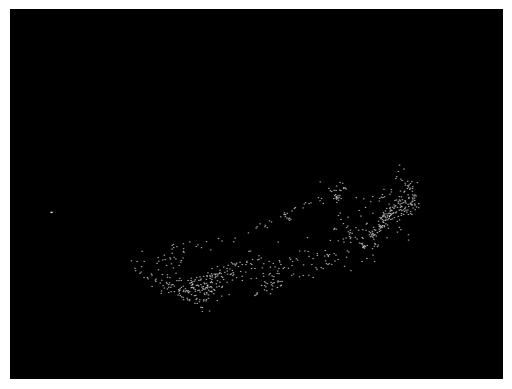

(4167, 5556)


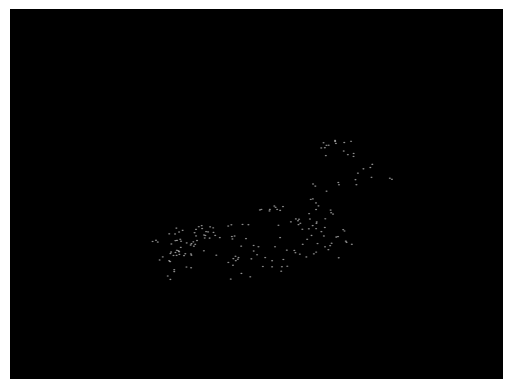

(4167, 5556)


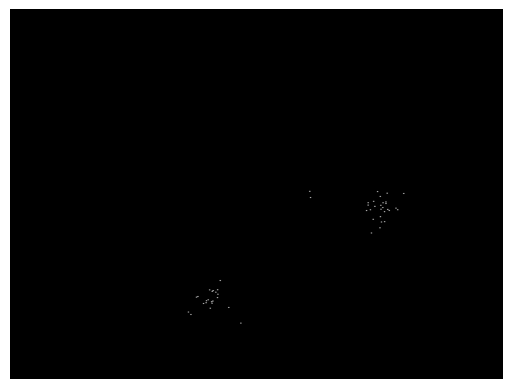

(4167, 5556)


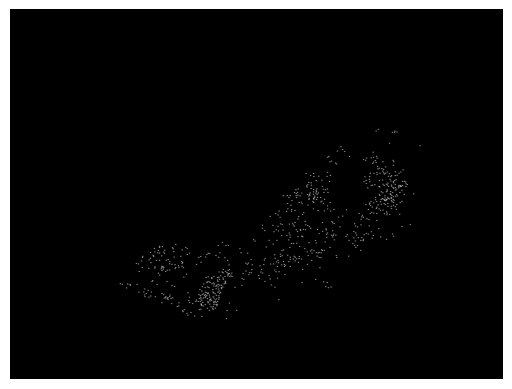

(4167, 5556)


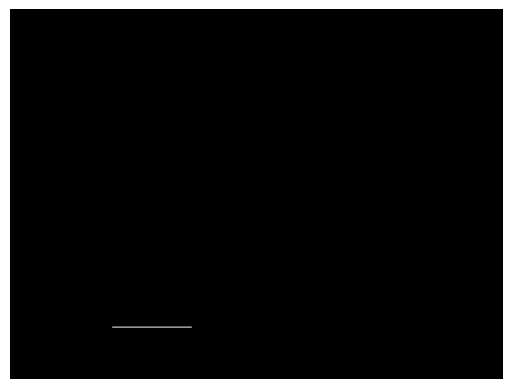

In [ ]:
images_out = preprocess(images_in, thresholds)
for image in images_out:
  print(image.shape)
  plot(image)

In [ ]:
contours_micron = cv2.findContours(images_out[-1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
contours_micron = sorted(contours_micron, key=cv2.contourArea, reverse=True)

# =====> Select Contour : Maximum Area <=====

m_line = contours_micron[0]
m_line = np.squeeze(m_line, axis = 1)

m_line = m_line[m_line[:, 0].argsort()]
one_micron = max(m_line[:, 0]) - min(m_line[:, 0])

print("========= One Micron in Pixels : ========", one_micron)


========= One Micron in Pixels : ======== 897




*  CANNY EDGE DETECTION



Analysing Image Boundary

1.  Find coordinates of separation boundary
2.  Find coordinates of  dorsal border : backward boundary
3.  Find coordinates of ventral border : forward boundary



In [ ]:
def get_coordinates(image_in):
  contours = cv2.findContours(image_in, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  coordinates = np.empty((0, 2))
  for contour in contours:

    points = np.squeeze(contour, axis = 1)
    centroid = np.mean(points, axis = 0)

    coordinates = np.vstack((coordinates, centroid))

  return coordinates


In [ ]:
def get_boundary(image_in):
  contours = cv2.findContours(image_in, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  boundary = np.squeeze(contours[0], axis = 1)
  return boundary

In [ ]:
points_Aldha1a1_plus = get_coordinates(images_out[-5])
points_Aldha1a1_mask_plus = get_coordinates(cv2.bitwise_and(images_out[-6], images_out[-5]))

points_Aldha1a1_neg = get_coordinates(images_out[-4])
points_Aldha1a1_mask_neg = get_coordinates(cv2.bitwise_and(images_out[-6], images_out[-4]))


points_anxa_pos = get_coordinates(images_out[-3])
points_anxa_neg = get_coordinates(images_out[-2])

In [ ]:
right_boundary = get_boundary(images_out[0])
left_boundary = get_boundary(images_out[1])

In [ ]:
def plot_boundary(points):
  plt.figure(figsize=(6,4), facecolor="black")

  plt.scatter(points[:,0], points[:,1],
              c="white", edgecolors="black", s=80, marker="o")
  plt.plot(points[:,0], points[:,1], color="red", linewidth=1)

  ax = plt.gca()
  ax.invert_yaxis()
  ax.set_facecolor("black")
  ax.tick_params(colors="white")

  plt.show()

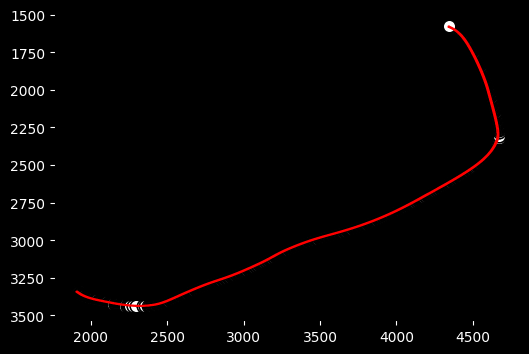

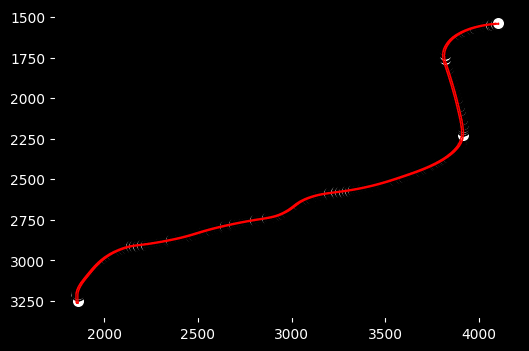

In [ ]:
plot_boundary(right_boundary)
plot_boundary(left_boundary)

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d, PchipInterpolator, splprep, splev
from shapely.geometry import Point, LineString
import math


def closest_point(splev, tck, x_p, y_p):
  def r(t):
        x, y = splev(t, tck)
        return np.array([x, y])
  res = minimize_scalar(lambda t: np.sum((r(t) - np.array([x_p, y_p]))**2), bounds=(0.0, 1.0), method='bounded')

  t_closest = res.x
  x_closest, y_closest = splev(t_closest, tck)

  dx_dt, dy_dt = splev(t_closest, tck, der=1)
  tangent = np.array([dx_dt, dy_dt])

  to_point = np.array([x_p - x_closest, y_p - y_closest])
  dot_val = float(np.dot(tangent, to_point))



  distance_closest = r(t_closest) - np.array([x_p, y_p])
  distance_closest = np.linalg.norm(distance_closest)
  return np.array([x_closest, y_closest]), distance_closest



def find_closest_points(border, points, title, enable_mask = False):

  ordered_points = order_points(border)

  tck, u = splprep([ordered_points[:,0], ordered_points[:,1]], s=0, per=False)
  u_fine = np.linspace(0, 1, 400)
  x_curve, y_curve = splev(u_fine, tck)

  closest_points = np.array([closest_point(splev, tck, x_p, y_p)[0] for x_p, y_p in points])

  distance = np.array([closest_point(splev, tck, x_p, y_p)[1] for x_p, y_p in points])

  # ----------- PLOT CURVE (DORSAL / VENTRAL ) POINTS ----------------


  plt.plot(x_curve, y_curve, label="Fitted Curve", color="black")
  plt.scatter(points[:, 0], points[:, 1], label="Points", color="red", marker='o', s = 10)
  plt.scatter(closest_points[:, 0], closest_points[:, 1], label="Closest Points", color="green", marker='x')


  for i in range(len(points)):

      plt.plot([points[i, 0], closest_points[i, 0]],
              [points[i, 1], closest_points[i, 1]],
              'gray', linestyle="dashed", linewidth=0.5)


  plt.legend()
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Shortest Distance : " + title)
  plt.axis("equal")
  plt.axis("scaled")
  plt.autoscale()
  plt.gca().invert_yaxis()
  plt.show()





  print("========== STATISTICS IN MICROMETRE ====================")

  mean = np.round(np.mean(distance) * 2 / one_micron, 2)
  std = np.round(np.std(distance) * 2 / one_micron, 2)
  max_dist = np.round(max(distance) * 2 / one_micron, 2)
  min_dist = np.round(min(distance) * 2 / one_micron, 2)
  median = np.round(np.median(distance) * 2 / one_micron, 2)

  Q1 = np.percentile(distance, 25)
  Q2 = np.percentile(distance, 50)  # This is the median
  Q3 = np.percentile(distance, 75)


  data = [
        ["Number of Cells", len(distance)],
        ["MEAN", mean],
        ["STDEV", std],
        ["MAX", std],
        ["MIN", std],
        ["MEDIAN", std],
        ["p25", Q1 / one_micron],
        ["p50", Q2 / one_micron],
        ["p75", Q3 / one_micron]
  ]
  df = pd.DataFrame(data, columns=["Metric", "Value"])
  print(df)
  print("========================================================")


In [ ]:
# ===========> ORDER BASED ON THE ANGLE FROM CENTROID <=================
def order_points(points):
  cx, cy = points.mean(axis=0)

  angles = np.arctan2(points[:,1] - cy, points[:,0] - cx)
  order = np.argsort(angles)
  ordered_points = points[order]

  ordered_points = np.vstack([ordered_points])
  return ordered_points


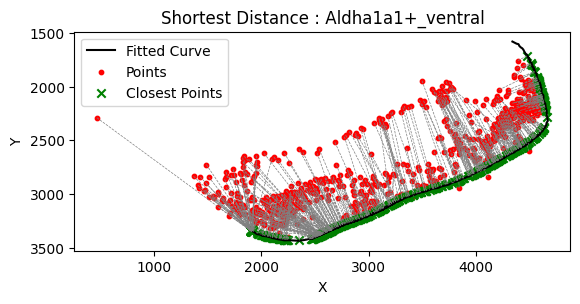

========== STATISTICS IN MICROMETRE ====================
            Metric       Value
0  Number of Cells  644.000000
1             MEAN    0.800000
2            STDEV    0.520000
3              MAX    0.520000
4              MIN    0.520000
5           MEDIAN    0.520000
6              p25    0.200854
7              p50    0.333606
8              p75    0.537832


In [ ]:
find_closest_points(right_boundary, points_Aldha1a1_plus, "Aldha1a1+_ventral")

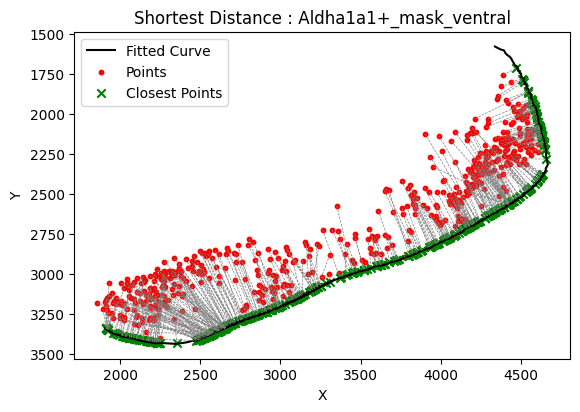

========== STATISTICS IN MICROMETRE ====================
            Metric       Value
0  Number of Cells  491.000000
1             MEAN    0.600000
2            STDEV    0.330000
3              MAX    0.330000
4              MIN    0.330000
5           MEDIAN    0.330000
6              p25    0.172368
7              p50    0.286367
8              p75    0.414935


In [ ]:
find_closest_points(right_boundary, points_Aldha1a1_mask_plus, "Aldha1a1+_mask_ventral")

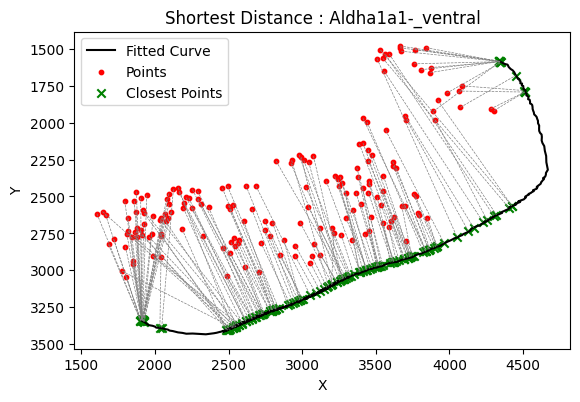

========== STATISTICS IN MICROMETRE ====================
            Metric       Value
0  Number of Cells  180.000000
1             MEAN    1.440000
2            STDEV    0.570000
3              MAX    0.570000
4              MIN    0.570000
5           MEDIAN    0.570000
6              p25    0.513111
7              p50    0.701620
8              p75    0.943861


In [ ]:
find_closest_points(right_boundary, points_Aldha1a1_neg, "Aldha1a1-_ventral")

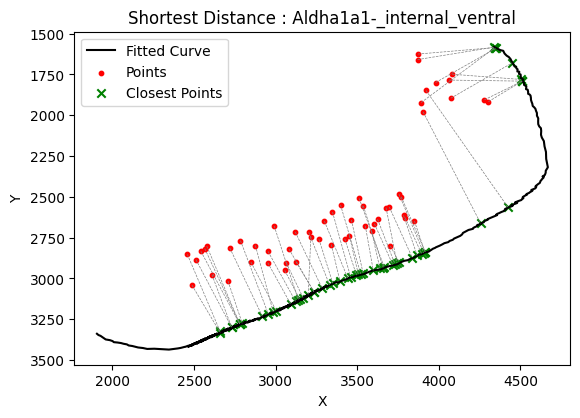

========== STATISTICS IN MICROMETRE ====================
            Metric      Value
0  Number of Cells  55.000000
1             MEAN   0.830000
2            STDEV   0.300000
3              MAX   0.300000
4              MIN   0.300000
5           MEDIAN   0.300000
6              p25   0.304910
7              p50   0.389926
8              p75   0.500541


In [ ]:
find_closest_points(right_boundary, points_Aldha1a1_mask_neg, "Aldha1a1-_internal_ventral")